# Rojové algoritmy

Na dnešním cvičení se podíváme na další druh přírodou inspirovaných algoritmů, který se používá pro optimalizační úlohy. Budou to takzvané rojové algoritmy, konkrétně algoritmus na optimalizaci pomocí hejna částic (Particle Swarm Optimization - PSO) a optimalizaci mravenčí kolonií (Ant Colony Optimization - ACO). Oba algoritmy jsou relativně jednoduché na implementaci, a proto si je napíšeme sami.

In [3]:
from collections import namedtuple
import math
import functools
import csv
import pprint

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc


## Particle Swarm Optimization

Nejprve se zkusíme podívat na algoritmus optimalizace hejnem částic. Implementace je snadná, protože de facto stačí jenom opsat rovnice.

Algoritmus otestujeme například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy (čtvrté cvičení). O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v počátku soustavy souřadnic - tedy v bodě 0 - s hodnotou 0.

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Vedle toho si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [4]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ", " + str(self.speed) + ", " + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. Dále budeme potřebovat funkci na update všech pozic a rychlostí částic v hejnu. Také bude potřeba funkce na update nejlepšího globálního řešení. Ještě si definujeme fitness funkci, která bude jen hodnota rastrigin funkce v daném bodě. Potom už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [25]:
# Random swarm initialization
def init_swarm(size, dimension):
    swarm = [Particle(
        position = np.random.uniform(size=(dimension)),
        speed = 0.2 * np.random.uniform(size=(dimension)) - 0.1
    ) for _ in range(size)]
    
    return swarm


# Swarm update
def update_swarm(swarm, fitness_function, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = \
            omega * particle.speed + \
            phi1 * np.random.random() * (particle.best_position - particle.position) + \
            phi2 * np.random.random() * (best_global - particle.position)
            
        particle.position = particle.position + particle.speed
        
        if fitness_function(particle.position) < fitness_function(particle.best_position):
            particle.best_position = particle.position

    return swarm


# Find global best
def compute_best_global_position(swarm, fitness_function):
    return min(swarm, key=lambda x: fitness_function(x.best_position)).best_position


# Rastrigin function as our "fitness" function, which we want to minimize
def fitness(position):
    N = len(position)
    A = 10
    value = A * N
    for i in range(len(position)):
        value += (position[i] * position[i]) - A * math.cos(2 * math.pi * position[i])

    return value


# PSO algorithm
def pso(fitness_function, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness_function)
    
    best_fitness = []
    for iteration in range(max_iters):
        # Update
        swarm = update_swarm(swarm, fitness_function, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness_function)
        
        # Logging
        print(f"Iteration {iteration:4}: {fitness_function(best_global_position):.6f}")
        best_fitness.append(fitness_function(best_global_position))
        
    return best_global_position, best_fitness

Pojďme tedy zkusit náš algoritmus otestovat.

Iteration    0: 3.408634
Iteration    1: 0.881746
Iteration    2: 0.238739
Iteration    3: 0.197438
Iteration    4: 0.101050
Iteration    5: 0.078089
Iteration    6: 0.005467
Iteration    7: 0.005467
Iteration    8: 0.005467
Iteration    9: 0.005467
Iteration   10: 0.005467
Iteration   11: 0.002515
Iteration   12: 0.002515
Iteration   13: 0.002515
Iteration   14: 0.002515
Iteration   15: 0.002515
Iteration   16: 0.001443
Iteration   17: 0.001410
Iteration   18: 0.001410
Iteration   19: 0.000802
Iteration   20: 0.000802
Iteration   21: 0.000802
Iteration   22: 0.000243
Iteration   23: 0.000243
Iteration   24: 0.000243
Iteration   25: 0.000243
Iteration   26: 0.000243
Iteration   27: 0.000243
Iteration   28: 0.000243
Iteration   29: 0.000243
Iteration   30: 0.000243
Iteration   31: 0.000243
Iteration   32: 0.000243
Iteration   33: 0.000243
Iteration   34: 0.000243
Iteration   35: 0.000243
Iteration   36: 0.000161
Iteration   37: 0.000161
Iteration   38: 0.000147
Iteration   39: 0.000147


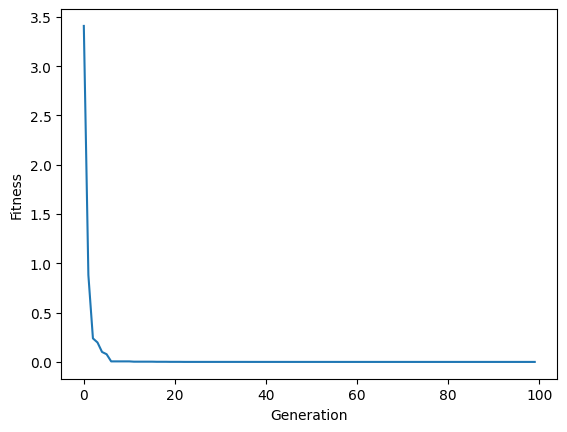

In [30]:
best_position, best_fitness = pso(fitness, swarm_size=1000, problem_dim=4, max_iters=100)

print("\nBest value and position:", fitness(best_position), "at position", best_position)

plt.plot(best_fitness)
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.show()

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.


## Ant Colony Optimization

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na hledání cest v grafu. Zkusíme si s jeho pomocí vyřešit problém obchodního cestujícího, který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Implementace už je trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci `namedtuple`, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu LRU (Least Recently Used) cache, která si pamatuje vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu vyhodnocovat. Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, že bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

In [7]:
Vertex = namedtuple("Vertex", ["name", "x", "y"])


@functools.lru_cache(maxsize=None)
def distance_function(v1, v2):
    return math.sqrt(((v1.x - v2.x) * (v1.x - v2.x)) + ((v1.y - v2.y) * (v1.y - v2.y)))


def fitness_function(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:] + solution[0:1]):
        solution_distance += distance(vertices[x], vertices[y])
    
    return solution_distance


Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, kde sice na začátku by z logiky věci měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo. Tak ji prostě nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně fitness, která říká, jak byla cesta dobrá. A protože délku chceme minimalizovat, tak použijeme inverz fitness, tedy *Q / fitness_value*, kde *Q* bude nějaká konstanta. Nesmíme zapomenout během updatu ani na vypařování feromonu.

In [8]:
def initialize_pheromone(N):
    return 0.01 * np.ones(shape=(N,N))


def update_pheromone(pheromones_array, solutions, fitness_values, Q, rho):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fitness_value in zip(solutions, fitness_values):
        for x, y in zip(solution, solution[1:] + solution[0:1]):
            pheromone_update[x, y] += Q / fitness_value
    
    return (1 - rho) * pheromones_array + pheromone_update


Ještě nám zbývá pomocná funkce, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. Tu napíšeme jako generátor, který postupně nageneruje řešení pro všechny mravence.

In [9]:
def generate_solutions(vertices, pheromones, distance_function, number_of_ants, alpha=1, beta=3):
    
    # Probability of selecting v2 right after v1
    def compute_prob(v1, v2):
        inverse_distance = 1 / distance_function(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(inverse_distance, beta)
        return ret if ret > 1e-6 else 1e-6

    number_of_vertices = len(vertices)
    for _ in range(number_of_ants):
        available = list(range(number_of_vertices))
        solution = [np.random.randint(0, number_of_vertices)]
        available.remove(solution[0])
        
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=(probs / np.sum(probs))) # Edge selection
            solution.append(selected)
            available.remove(selected)
            
        yield solution

 Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [10]:
# Main ACO code
def ant_solver(vertices, distance_function, number_of_ants=10, max_iterations=1000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float("inf")
    log_of_best_distances = list()
    
    print("Iteration\tMinimum value\tMean value\tMaximum value")
    
    for i in range(max_iterations):
        candidate_solutions = list(generate_solutions(vertices, pheromones, distance_function, number_of_ants, alpha=alpha, beta=beta))
        fitness_values = list(map(lambda x: fitness_function(vertices, distance_function, x), candidate_solutions))
        pheromones = update_pheromone(pheromones, candidate_solutions, fitness_values, Q=Q, rho=rho)
        
        for candidate_solution, fitness_value in zip(candidate_solutions, fitness_values):
            if fitness_value < best_fitness:
                best_fitness = fitness_value
                best_solution = candidate_solution
                
        log_of_best_distances.append(np.min(fitness_values))
        
        print(f"{i:8}:\t{np.min(fitness_values):5.8f}\t{np.mean(fitness_values):5.8f}\t{np.max(fitness_values):5.8f}")
        
    return best_solution, pheromones, log_of_best_distances

Zkusíme si nyní algoritmus otestovat na hlavních evropských městech, vstupní data jsou uložena v souboru *cities.csv*.

In [11]:
vertices = []
with open("cities.csv") as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

Iteration	Minimum value	Mean value	Maximum value
       0:	352.00692835	382.69016555	404.85765351
       1:	297.14849124	328.81554593	360.52326751
       2:	274.85285457	303.36014635	334.45356375
       3:	266.98070205	295.60823815	352.00627366
       4:	255.37340530	292.86518372	318.88180527
       5:	264.29262493	295.05246643	329.83154680
       6:	255.03750894	290.28071524	344.16040058
       7:	263.67236305	302.55692858	350.42822118
       8:	272.77358029	312.67669658	387.18583720
       9:	279.42417651	311.14964449	381.07567316
      10:	279.70446475	303.81363916	361.20270862
      11:	269.51733142	299.62433293	329.91750750
      12:	276.02958391	305.15074487	337.34517404
      13:	262.43028660	297.20560362	331.80172763
      14:	265.37368645	304.99344661	365.78040612
      15:	258.60885202	303.30950648	332.35322043
      16:	252.76063108	313.94846241	376.32901553
      17:	261.81563388	308.04476782	343.12071262
      18:	270.94395597	309.50126012	346.75767898
      19:	247.052182

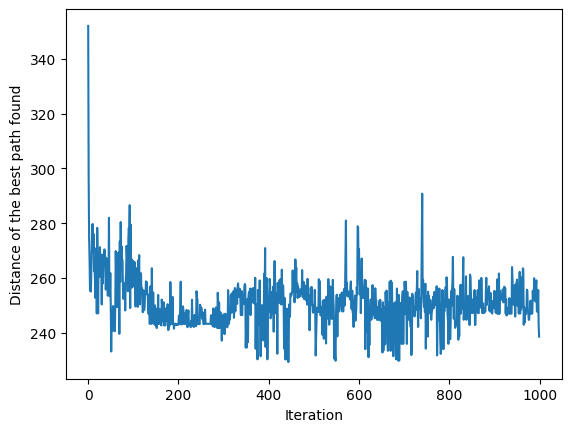

In [12]:
best_solution, pheromones, log_of_best_distances = ant_solver(vertices, distance_function)

plt.plot(log_of_best_distances)
plt.ylabel("Distance of the best path found")
plt.xlabel("Iteration")
plt.show()

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení.

Fitness:  260.4825168997816


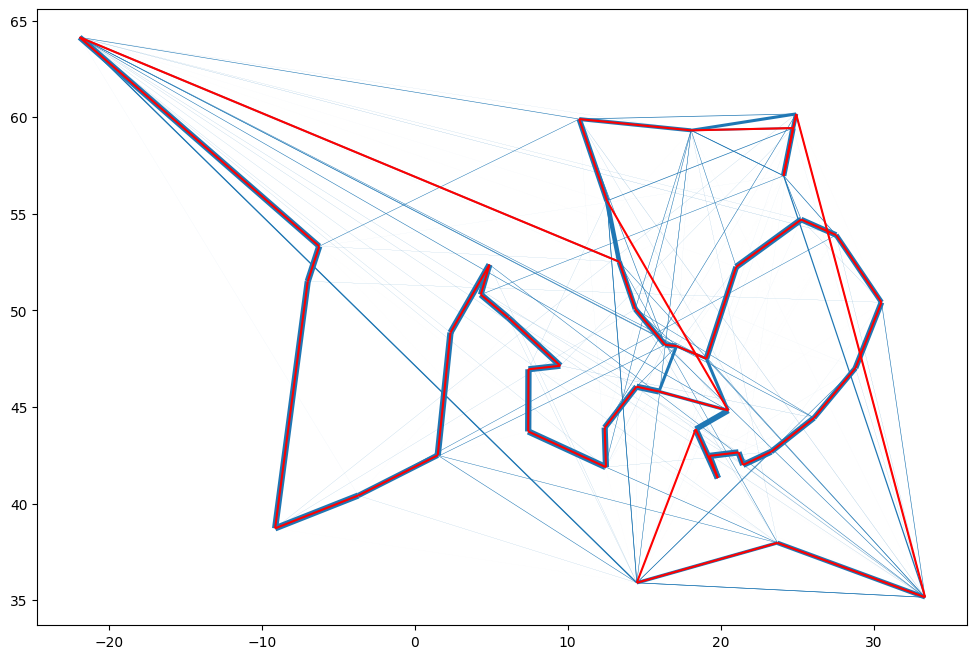

[Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='Monaco', x=7.416666667, y=43.73333333),
 Vertex(name='Bern', x=7.433333333, y=46.95),
 Vertex(name='Vaduz', x=9.516666667, y=47.13333333),
 Vertex(name='Luxemburg', x=6.116666667, y=49.61666667),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Amsterdam', x=4.883333333, y=52.36666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Madrid', x=-3.7, y=40.41666667),
 Vertex(name='Lisbon', x=-9.133333333, y=38.71666667),
 Vertex(name='London', x=-7.0, y=51.5),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Prague', x=14.41666667, 

In [ ]:
# Render pheromones (blue, line width corresponds to the pheromon value on the edge)
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i, j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# Here, you can test the influence of the individual parameters on the generated candidate solution
# solution = list(generate_solutions(vertices, pheromones, distance_function, number_of_ants=1, alpha=3, beta=1))[0]

# Print solution's fitness
print("Fitness: ", fitness_function(vertices, distance_function, solution))

# Render the solution (red)
solution_lines = []
for i, j in zip(solution, solution[1:] + solution[0:1]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])

solutions_lc = mc.LineCollection(solution_lines, colors="red")

ax.add_collection(solutions_lc)

plt.show()

# Print towns in the order of the soultion
solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

Jen tak pro zajímavost, rozhraní pro modelování různých přírodou inspirovaných systémů a algoritmů [NetLogo](http://ccl.northwestern.edu/netlogo/) poskytuje i simulaci mravenců při hledání potravy. Podívat se na ně můžeme [zde](http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Ants.nlogo).

## Úkol na cvičení

Pohrejte si s PSO, ať vidíte, jak dimenze problému ovlivňují potřebný počet částic, a zároveň ať si empiricky ověříte, že algoritmu stačí nemnoho iterací, více že mu stejně většinou příliš nepomůže. (Můžete samozřejmě funkci i upravit a hrát si i s hyperparametry.)

Vyzkoušejte si chování ACO v závislosti na různém nastavení hyperparametrů. Všimněte si, že $\alpha$ a $\beta$ jsou svým způsobem provázané hyperparametry, neboť v podstatě odpovídají váhám (multiplikativní) kombinace feromonů a heuristické funkce. Dále $\alpha$ (a tranzitivně tak i $\beta$) je závislé na hodnotě hyperparametrů *Q* a $\rho$, neboť ty mi určují, kolik tak zhruba budu mít feromonů na každé hraně v každé iteraci. Nakonec pak *Q* (a potažmo i $\alpha$) je závislé na hodnotách "fitness" funkce, která mi dává kvalitu každého řešení, protože by mi hodnota *Q* měla nějakým způsobem vyvažovat magnitudu této funkce. Vymysleli byste nějaká vylepšení k našemu kódu, která by koncepčně mohla pomoct s naší úlohou? (Například update feromonů by dávalo smysl trochu upravit. Jak? Proč?)

## Domácí úkol - Vehicle routing problem

Za domácí úkol budete mít vyřešit Vehicle routing problem pomocí ACO. Jedná se v podstatě o zobecnění problému obchodního cestujícího, kde cílem je optimalizovat dodání zásilek jejich adresátům za pomoci několika vozů.

[Detailní zadání](https://kam.mff.cuni.cz/~lorenc/teach/PIA_hw/homeworks-routing.html) je možno najít na stránkách cvičení.